# Social information for friendship network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import timeit
import math
import random
import feather as ft

## Know something fundamentals of friendship network in Weeplace datset

In [ ]:
df_friend = pd.read_csv('data/weeplace_friends.csv')
df_wp = ft.read_dataframe('data/weeplace_checkins_without_loc_NA.feather') # it is the dataset without NA location

In [ ]:
df_wp_origin = pd.read_csv('data/weeplace_checkins.csv')  # this is original Weeplace dataset without any processing, including some NA location

In [43]:
df_wp_origin = df_wp_origin.dropna(subset=["placeid",'userid', 'datetime'])
print(len(set(df_wp_origin['userid'].tolist())), len(set(df_wp['userid'].tolist())))

15793 15793


Check all the users in friendship network whether they have mobility data in Weeplace dataset

In [42]:
TrueUser1 = set(df_friend['userid1'].tolist())
TrueUser2 = set(df_friend['userid2'].tolist())
UsedUser = set(df_wp['userid'].tolist())

if UsedUser.issubset(TrueUser1) & UsedUser.issubset(TrueUser2):
    print('All used users appear in the true friendship network')

All used users appear in the true friendship network


In [44]:
print(len(TrueUser1), len(TrueUser2), len(UsedUser))

16021 16022 15793


It appears that the true friendship has more users than used mobility data, that is to say, some of users in friendship network have no mobility infomration. The following `TrueUser1 - UsedUser` shows the users appear in frienship network (user1) but do not have mobility information, similar meaning in `TrueUser2 - UsedUser`.

In [ ]:
TrueUser1 - UsedUser

In [ ]:
TrueUser2 - UsedUser

In [45]:
print('There are ', len(TrueUser1 - UsedUser), 'users (user1) in true friendship who do not have mobility data information')

There are  228 users (user1) in true friendship who do not have mobility data information


In [46]:
print('There are ', len(TrueUser2 - UsedUser), 'users (user2) in true friendship who do not have mobility data information')

There are  229 users (user2) in true friendship who do not have mobility data information


Therefore, we remove all the users in friendship network who do not have mobility information

In [ ]:
df_friend_used = df_friend[df_friend['userid1'].isin(UsedUser) & df_friend['userid2'].isin(UsedUser)]

In [47]:
print('We remove', str(df_friend.shape[0] - df_friend_used.shape[0]), 'records in friendship network with no mobility data')

We remove 5819 records in friendship network with no mobility data


In [ ]:
num_friend = df_friend.groupby('userid1').count()['userid2'].reset_index(name='count').sort_values('count', ascending=False)
num_friend

In [ ]:
num_friend_used = df_friend_used.groupby('userid1').count()['userid2'].reset_index(name='count').sort_values('count', ascending=False)
num_friend_used 

In [48]:
print('In fact, we remove', str(num_friend.shape[0] - num_friend_used.shape[0]), 'users in friendship network')

In fact, we remove 489 users in friendship network


In [ ]:
# from scipy.optimize import curve_fit

# # exponential fit for the number of friends
# def exp_fit(rdata, A, alpha):
#     return A*rdata**(-alpha)

# NumFriendsHist = np.histogram(num_friend[['count']],density=True, bins=100)

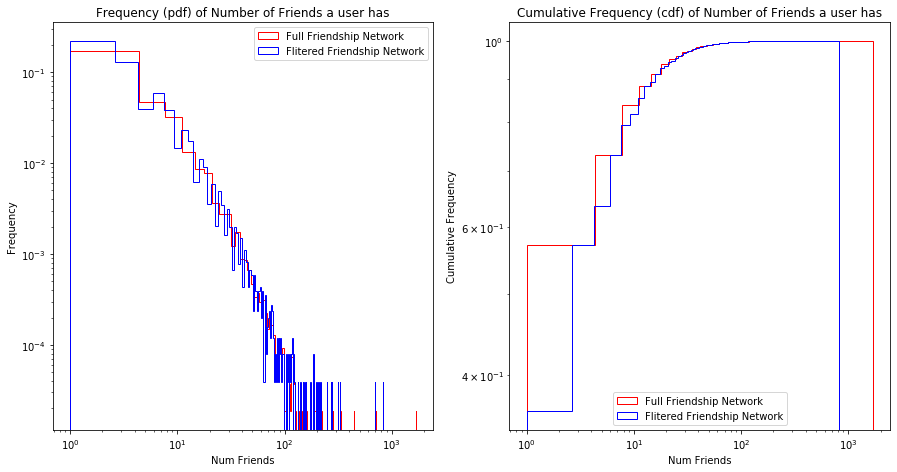

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7.5))

num_friend[['count']].plot.hist(bins=500, density=True, ax=ax1, histtype='step', color='red')
num_friend_used[['count']].plot.hist(bins=500, density=True, ax=ax1, histtype='step', color='blue')
ax1.set(xlabel='Num Friends', ylabel='Frequency', xscale='log', yscale='log',
       title='Frequency (pdf) of Number of Friends a user has')
ax1.legend(['Full Friendship Network', 'Flitered Friendship Network'])

num_friend[['count']].plot.hist(bins=500, density=True, ax=ax2, histtype='step', color='red', cumulative=True)
num_friend_used[['count']].plot.hist(bins=500, density=True, ax=ax2, histtype='step', color='blue', cumulative=True)
ax2.set(xlabel='Num Friends', ylabel='Cumulative Frequency', xscale='log', yscale='log',
       title='Cumulative Frequency (cdf) of Number of Friends a user has')
ax2.legend(['Full Friendship Network', 'Flitered Friendship Network'], loc=8)

plt.show()

After filtering, we only have less users, but from the view of hist fit (log view), it is acceptable.

## Compute entropy for all users

In [ ]:
from entropy_functions import shannon_entropy, entropy, cross_entropy,LZ_entropy
import pickle

* **NOTICE**: now we only consider user's visitation as the **time-ordered sequence** rather than **temporal sequence**, and then compute shannon entropy and LZ-entropy

In [ ]:
""" Extract time-ordered placeid sequences for all users"""
num_used_users = len(UsedUser)

# # this placeid store only include all the users who appear in the true friendship network
# placeid_store = np.empty(num_used_users, dtype=object)

# for i in range(num_used_users):
#     placeid_store[i] = df_wp[df_wp['userid'] ==list(UsedUser)[i]].set_index('datetime').sort_index()['placeid'].to_list()

# # save pickle file
# pickle_out = open("placeid.pickle", "wb")
# pickle.dump(placeid_store, pickle_out)
# pickle_out.close()

# read picle file
pickle_in = open("placeid.pickle", "rb")
placeid_store = pickle.load(pickle_in)

Now we can compute shanon entropy and LZ-entropy for all the users and plot the histograms

In [ ]:
user_shannon_entropy = [shannon_entropy(placeid_store[i]) for i in range(num_used_users)]

In [ ]:
user_LZ_entropy = [entropy(placeid_store[i]) for i in range(num_used_users)]

In [ ]:
user_LZ_entropy_filter = [LZ_entropy(placeid_store[i]) for i in range(num_used_users)]

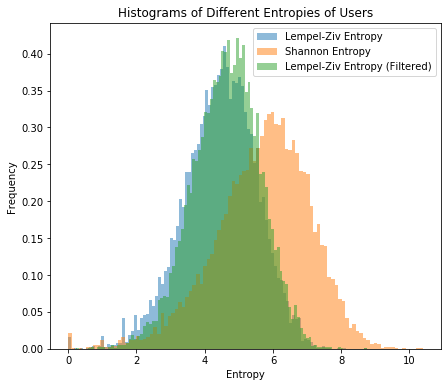

In [39]:
plt.figure(figsize=(7, 6))
plt.title('Histograms of Different Entropies of Users')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.hist(user_LZ_entropy,bins = 100,density = True, label = 'Lempel-Ziv Entropy',alpha=.5)
plt.hist(user_shannon_entropy ,bins = 100,density = True, label = 'Shannon Entropy',alpha=.5)
user_array_LZ_entropy = np.array(user_LZ_entropy_filter)
plt.hist(user_array_LZ_entropy[~np.isnan(user_array_LZ_entropy)],bins = 100,density = True, label = 'Lempel-Ziv Entropy (Filtered)',alpha=.5)
plt.legend()
plt.show()

In [ ]:
""" Compute predictability given the lengths of sequences and the LZ-entropy"""
import mpmath

# As required by algorithm, N should be large, we set e as the threshold of N. 
# if it is smaller than threshold, we will just print NA
def getPredictability(N, S, e=100):
    if N >= e:
        f = lambda x: (((1-x)/(N-1)) **(1-x))* x**x - 2**(-S)
        root = mpmath.findroot(f, 1)
        return float(root.real)
    else: 
        return np.nan

* **NOTICE**: Be careful, I remove all placeid sequence whose length is less than 100.

In [ ]:
# I set e=100 now
user_predictability = [getPredictability(len(placeid_store[i]),user_LZ_entropy[i]) for i in range(num_used_users)]

In [37]:
# I set e=2 now
user_predictability2 = [getPredictability(len(placeid_store[i]),user_LZ_entropy[i], 2) for i in range(num_used_users)]

Compare with two thresholds, e = 100 and e=2, that is to say, we remove all the users' information if their the lengths of their placeid string are no more than e

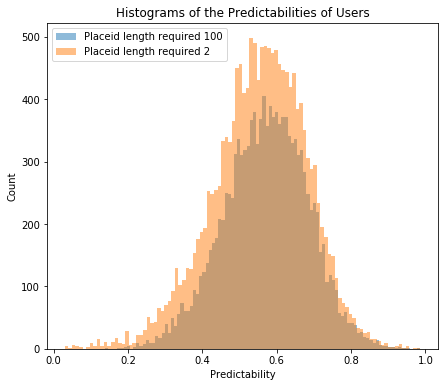

In [139]:
plt.figure(figsize=(7, 6))
plt.title('Histograms of the Predictabilities of Users')
plt.xlabel('Predictability')
plt.ylabel('Count')
user_array_pred = np.array(user_predictability)
user_array_pred2 = np.array(user_predictability2)
plt.hist(user_array_pred[~np.isnan(user_array_pred)],bins = 100,label='Placeid length required 100', alpha=.5)
plt.hist(user_array_pred2[~np.isnan(user_array_pred2)],bins = 100, label='Placeid length required 2', alpha=.5)
plt.legend()
plt.show()

## Let's go to cross entropy and cumulative cross entropy

In [ ]:
""" Extract time-ordered placeid sequences (with temporal information) for all users"""

# # this is list
# temporal_placeid_store = [df_wp[df_wp['userid'] ==list(UsedUser)[i]].set_index('datetime').sort_index()[['placeid']] for i in range(num_used_users)]

# # # this is dict, dict will more faster!!!
# temporal_placeid_dict = {list(UsedUser)[i]: df_wp[df_wp['userid'] ==list(UsedUser)[i]].set_index('datetime').sort_index()[['placeid']] \
#                                for i in range(num_used_users)}

# # save pickle file
# pickle_out = open("temporal_placeid_dict.pickle", "wb")
# pickle.dump(temporal_placeid_dict, pickle_out)
# pickle_out.close()

# read picle file
pickle_in = open("temporal_placeid_dict.pickle", "rb")
temporal_placeid_dict = pickle.load(pickle_in)

In [ ]:
""" Using cross_entropy function to compute cumulative cross entropy for all users"""
used_user_list = list(UsedUser)
user_info= dict()
user_friends= dict()

for ego in used_user_list:
    ego_temporal_placeid = temporal_placeid_dict[ego]
    ego_time = pd.to_datetime(ego_temporal_placeid.index).tolist()
    ego_placeid = ego_temporal_placeid['placeid'].tolist()
    N_uniq_placeid = len(set(ego_placeid))
    length_ego = len(ego_placeid)
    
    # find all the alters for the ego
    alters = df_friend_used[df_friend_used['userid1']==ego]['userid2'].tolist()
    
    N_alters = len(alters)
    length_alters = [None] * N_alters
    
    """For cumulative cross entropy, largest L for all alters, and then get sum"""
    L = [None] * N_alters
    
    for j in range(N_alters):
        alter = alters[j]
        alter_temporal_placeid = temporal_placeid_dict[alter]
        
        alter_time = pd.to_datetime(alter_temporal_placeid.index).tolist()
        alter_placeid = alter_temporal_placeid['placeid'].tolist()
        
        """Be careful: W1 in cross_entropy is B in the paper, W2 is cross_entropy is A in the paper """        
        # so we need to get the relative time order of ego in alter (abosulte position of ego+alter)
        # for function cross_entropy, we need to have PTs
        total_time = sorted(ego_time + alter_time)
        PTs = [total_time.index(x) for x in ego_time]
        
        """ function cross_entropy can return L, as defintion of cumulative cross entropy, we need to get max """
        L[j] = cross_entropy(alter_placeid,ego_placeid, PTs, lambdas=True)
        length_alters[j] = len(alter_placeid)
    
    # use axis=0 and get max as the definition in the paper 
    L_max = np.amax(L, axis=0)
    
    ego_cross_entropy = (1.0*length_ego/sum(L_max)) * math.log(np.mean(length_alters),2)
    
    # compute shannon entropy
    ego_shannon_entropy = shannon_entropy(ego_placeid)
    
    # compute entropy (it is LZ-entropy without filter)
    ego_LZ_entropy = entropy(ego_placeid)
    
    # compute entropy (least number of placeid required)
    ego_LZ_entropy2 = LZ_entropy(ego_placeid, e=2)
    ego_LZ_entropy10 = LZ_entropy(ego_placeid, e=10)
    ego_LZ_entropy100 = LZ_entropy(ego_placeid, e=100)
    
    # compute predictability (use Fano equation and solve the equation)
    # different numbers of points are required
    ego_predictability100 = getPredictability(length_ego, ego_LZ_entropy100, e=100)
    ego_predictability10 = getPredictability(length_ego, ego_LZ_entropy10, e=10)
    ego_predictability2 = getPredictability(length_ego, ego_LZ_entropy2, e=2)
    
    # predictability derived from cross-entropy
    ego_cross_predictability2 = getPredictability(length_ego, ego_cross_entropy, e=2)
    
    # store 'N-placeid','N-unique placeid', N-alters', and different 'entropy' and'cross-entropy' in order 
    user_info[ego] = [length_ego, 
                      N_uniq_placeid,
                      N_alters, 
                      # different entropies
                      ego_shannon_entropy,
                      ego_LZ_entropy,
                      ego_LZ_entropy2,
                      ego_LZ_entropy10,
                      ego_LZ_entropy100,
                      # different predictabilities
                      ego_predictability2,
                      ego_predictability10,
                      ego_predictability100,
                      # cross entropy
                      ego_cross_entropy,
                      # predictability associate with cross entropy
                      ego_cross_predictability2
                     ]
    
    user_friends[ego] = {'alters': alters,
                        'temporal-placeid': ego_temporal_placeid
                        }

# save pickle file
pickle_out = open("user_info.pickle", "wb")
pickle.dump(user_info, pickle_out)
pickle_out.close()

pickle_out = open("user_friends.pickle", "wb")
pickle.dump(user_friends, pickle_out)
pickle_out.close()

# # read picle file
# pickle_in = open("user_info.pickle", "rb")
# user_info = pickle.load(pickle_in)

In [201]:
pd.DataFrame.from_dict(user_info, orient='index',
                       columns=['NumPlaceid','NumUniqPlaceid', 'NumFriends',
                                'ShannonEntropy', 'LZ_entropy', 'LZ_entropy2', 'LZ_entropy10', 'LZ_entropy100',
                                'Predictability2', 'Predictability10', 'Predictability100',
                                'CrossEntropy', 'CrossPredictability2'])

,NumPlaceid,NumUniqPlaceid,NumFriends,ShannonEntropy,LZ_entropy,LZ_entropy2,LZ_entropy10,LZ_entropy100,Predictability2,Predictability10,Predictability100,CrossEntropy,CrossPredictability2
linus-oura,202,100,3,5.658225,4.382319,4.382319,4.382319,4.382319,0.556712,0.556712,0.556712,5.847956,0.358739
carlos-granier-phelps,488,156,8,5.924540,4.438085,4.438085,4.438085,4.438085,0.610893,0.610893,0.610893,6.493165,0.380012
brian-niedfeldt,80,46,2,5.140111,4.250036,4.250036,4.250036,NaN,0.484318,0.484318,NaN,8.039260,-0.246740
horacio-garay,282,76,12,3.544559,2.883610,2.883610,2.883610,2.883610,0.746009,0.746009,0.746009,3.343534,0.697656
ben-samples,228,115,2,6.238941,5.016570,5.016570,5.016570,5.016570,0.486737,0.486737,0.486737,7.091019,0.181210
brian-skahan,169,80,7,5.515207,4.388592,4.388592,4.388592,4.388592,0.540951,0.540951,0.540951,5.178084,0.433053
mr_tanshin,21,10,2,3.118275,2.635390,2.635390,2.635390,NaN,0.613006,0.613006,NaN,4.955178,-0.052467
alex-popescu6,93,78,5,6.208461,5.630942,5.630942,5.630942,NaN,0.264619,0.264619,NaN,6.770829,-0.031940
gijsbregt-brouwer,828,311,32,6.924439,5.089542,5.089542,5.089542,5.089542,0.576299,0.576299,0.576299,4.893727,0.595510
ronsho,48,37,22,4.996115,4.622038,4.622038,4.622038,NaN,0.333183,0.333183,NaN,5.223877,0.183241


In [200]:
user_info

{'linus-oura': [202,
  100,
  3,
  5.658225081876249,
  4.38231931874182,
  4.38231931874182,
  4.38231931874182,
  4.38231931874182,
  0.5567119929178287,
  0.5567119929178287,
  0.5567119929178287,
  5.847955772979502,
  0.3587385258029757],
 'carlos-granier-phelps': [488,
  156,
  8,
  5.924540274849883,
  4.438085357159561,
  4.438085357159561,
  4.438085357159561,
  4.438085357159561,
  0.6108926228990639,
  0.6108926228990639,
  0.6108926228990639,
  6.493165057290893,
  0.3800120781936515],
 'brian-niedfeldt': [80,
  46,
  2,
  5.140111376837555,
  4.250035694041924,
  4.250035694041924,
  4.250035694041924,
  nan,
  0.4843181389678829,
  0.4843181389678829,
  nan,
  8.039259993698359,
  -0.24673960955952476],
 'horacio-garay': [282,
  76,
  12,
  3.544559030406585,
  2.8836099012267082,
  2.8836099012267082,
  2.8836099012267082,
  2.8836099012267082,
  0.7460093943867521,
  0.7460093943867521,
  0.7460093943867521,
  3.3435343335156915,
  0.6976557858711238],
 'ben-samples': [